In [364]:
# %load_ext autoreload
# %autoreload 2

import sys
sys.path.append('..')

from events_calc import precip_events
from lib.obs import hourly_precip
from lib.enso import oni_trimonthly

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# suppress warnings
pd.options.mode.chained_assignment = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load hourly precip data for SFO

In [259]:
sfo_precip = hourly_precip('SFO', '1950-07-01', '2021-06-30')

In [205]:
sfo_precip.head()

,station,network,valid,precip_in
0,SFO,CA_ASOS,1950-09-17 19:00:00,0.09
1,SFO,CA_ASOS,1950-09-17 20:00:00,0.02
2,SFO,CA_ASOS,1950-10-17 05:00:00,0.03
3,SFO,CA_ASOS,1950-10-17 15:00:00,0.01
4,SFO,CA_ASOS,1950-10-23 17:00:00,0.01


In [732]:
eps = 12
min_samples = 10
rain_event_labels = precip_events(sfo_precip, eps, min_samples, chunks=50)

In [733]:
sfo_precip_temp = sfo_precip.copy()
sfo_precip_temp['clust'] = rain_event_labels
sfo_precip_temp = sfo_precip_temp[sfo_precip_temp.clust >= 0]

In [734]:
sfo_precip_temp.tail()

,station,network,valid,precip_in,clust
24581,SFO,CA_ASOS,2021-03-18 21:00:00,0.05,1827
24582,SFO,CA_ASOS,2021-03-18 22:00:00,0.01,1827
24583,SFO,CA_ASOS,2021-03-18 23:00:00,0.01,1827
24584,SFO,CA_ASOS,2021-03-19 00:00:00,0.02,1827
24587,SFO,CA_ASOS,2021-06-15 20:00:00,0.57,1828


In [735]:
def calc_past_24_all(df):
    def calc_past_24_row(t):
        t_minus24 = t - pd.Timedelta(24, 'h')
        df_subset = df[(df.valid > t_minus24) & (df.valid <= t)]
        if len(df_subset) == 0:
            return 0
        return df_subset.precip_in.sum()
    return df.apply(lambda row: calc_past_24_row(row.valid), axis=1)

In [736]:
precip_24hr_clust = sfo_precip_temp.groupby('clust', as_index=False).apply(calc_past_24_all)

In [737]:
precip_24hr_clust_id = precip_24hr_clust.reset_index(name='precip_24_hr')['precip_24_hr']
precip_24hr_clust_id.index = sfo_precip_temp.index
sfo_precip_temp['precip_in_24hr']= precip_24hr_clust_id

In [738]:
sfo_precip_temp.tail()

,station,network,valid,precip_in,clust,precip_in_24hr
24581,SFO,CA_ASOS,2021-03-18 21:00:00,0.05,1827,0.12
24582,SFO,CA_ASOS,2021-03-18 22:00:00,0.01,1827,0.13
24583,SFO,CA_ASOS,2021-03-18 23:00:00,0.01,1827,0.14
24584,SFO,CA_ASOS,2021-03-19 00:00:00,0.02,1827,0.16
24587,SFO,CA_ASOS,2021-06-15 20:00:00,0.57,1828,0.57


In [739]:
sfo_rain_events = sfo_precip_temp.groupby('clust', as_index=False).agg({
    'precip_in': sum,
    'valid': [lambda r: pd.Timestamp(np.nanmean([tsp.value for tsp in r])), min, max],
    'precip_in_24hr': max
})
sfo_rain_events.columns.droplevel(level=0)
sfo_rain_events.columns = ['clust', 'precip', 'mean_time', 'min_time', 'max_time', 'max_precip_24hr']

In [740]:
def get_max_precip_hr(precip, clust):
    row = sfo_precip_temp[(sfo_precip_temp.precip_in_24hr == precip) & (sfo_precip_temp.clust == clust)]
    return row.valid.values[0]
    
sfo_rain_events['max_precip_hr'] = sfo_rain_events.apply(lambda r: get_max_precip_hr(r.max_precip_24hr, r.clust), axis=1)

In [741]:
sfo_rain_events.sort_values(by='max_precip_24hr', ascending=False).head(10)

,clust,precip,mean_time,min_time,max_time,max_precip_24hr,max_precip_hr
775,775,6.51,1982-01-04 17:09:05.454545472,1982-01-04 01:00:00,1982-01-05 14:00:00,5.71,1982-01-05 08:00:00
414,414,5.98,1967-01-21 08:30:00.000000000,1967-01-20 12:00:00,1967-01-22 05:00:00,4.58,1967-01-22 03:00:00
316,316,6.94,1962-10-13 02:23:15.918367360,1962-10-11 14:00:00,1962-10-14 05:00:00,3.74,1962-10-14 00:00:00
1680,1680,3.81,2014-12-12 03:45:00.000000000,2014-12-11 13:00:00,2014-12-13 07:00:00,3.54,2014-12-12 10:00:00
1754,1754,3.54,2018-01-08 21:30:00.000000000,2018-01-08 08:00:00,2018-01-09 11:00:00,3.44,2018-01-09 10:00:00
1222,1222,8.16,1998-02-05 00:11:24.000000128,1998-02-01 13:00:00,1998-02-08 23:00:00,3.41,1998-02-03 12:00:00
137,137,5.56,1955-12-23 00:30:31.578947392,1955-12-21 15:00:00,1955-12-24 09:00:00,3.33,1955-12-23 22:00:00
1144,1144,4.22,1995-12-12 00:45:00.000000000,1995-12-11 00:00:00,1995-12-12 19:00:00,3.18,1995-12-12 08:00:00
1064,1064,3.71,1993-01-13 13:05:08.571428608,1993-01-12 18:00:00,1993-01-14 19:00:00,3.00,1993-01-13 22:00:00
1339,1339,3.32,2001-12-02 08:50:16.216216192,2001-12-01 06:00:00,2001-12-03 22:00:00,2.89,2001-12-02 15:00:00


In [742]:
sfo_rain_events.sort_values(by='precip', ascending=False).head(10)

,clust,precip,mean_time,min_time,max_time,max_precip_24hr,max_precip_hr
1222,1222,8.16,1998-02-05 00:11:24.000000128,1998-02-01 13:00:00,1998-02-08 23:00:00,3.41,1998-02-03 12:00:00
316,316,6.94,1962-10-13 02:23:15.918367360,1962-10-11 14:00:00,1962-10-14 05:00:00,3.74,1962-10-14 00:00:00
908,908,6.65,1986-02-16 23:49:40.645161280,1986-02-14 01:00:00,1986-02-20 18:00:00,1.84,1986-02-17 20:00:00
775,775,6.51,1982-01-04 17:09:05.454545472,1982-01-04 01:00:00,1982-01-05 14:00:00,5.71,1982-01-05 08:00:00
414,414,5.98,1967-01-21 08:30:00.000000000,1967-01-20 12:00:00,1967-01-22 05:00:00,4.58,1967-01-22 03:00:00
137,137,5.56,1955-12-23 00:30:31.578947392,1955-12-21 15:00:00,1955-12-24 09:00:00,3.33,1955-12-23 22:00:00
1564,1564,4.99,2010-01-20 19:24:10.000000000,2010-01-17 15:00:00,2010-01-23 20:00:00,1.85,2010-01-19 16:00:00
224,224,4.69,1958-04-03 02:35:10.344827584,1958-04-01 07:00:00,1958-04-04 21:00:00,2.66,1958-04-03 12:00:00
786,786,4.39,1982-03-30 17:10:31.578947392,1982-03-28 09:00:00,1982-04-01 20:00:00,2.46,1982-03-31 20:00:00
1144,1144,4.22,1995-12-12 00:45:00.000000000,1995-12-11 00:00:00,1995-12-12 19:00:00,3.18,1995-12-12 08:00:00


# Look at rainfall distribution of rain events

In [743]:
sfo_rain_events.max_precip_24hr.describe()

count    1829.000000
mean        0.601471
std         0.554392
min         0.100000
25%         0.210000
50%         0.410000
75%         0.800000
max         5.710000
Name: max_precip_24hr, dtype: float64

In [744]:
sfo_rain_events.precip.describe()

count    1829.000000
mean        0.698753
std         0.769774
min         0.100000
25%         0.210000
50%         0.430000
75%         0.880000
max         8.160000
Name: precip, dtype: float64

Text(0, 0.5, 'Count')

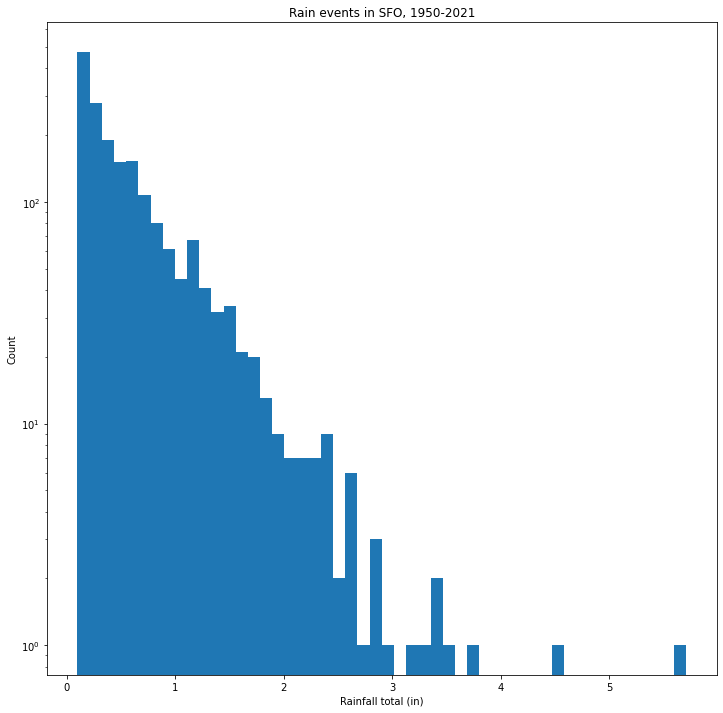

In [745]:
plt.figure(figsize=(12, 12))
plt.hist(sfo_rain_events.max_precip_24hr, bins=50, log=True)
plt.title('Rain events in SFO, 1950-2021')
plt.xlabel('Rainfall total (in)')
plt.ylabel('Count')

# Visualized Clusters

In [832]:
def plot_rain_janfeb(year, figsize=None, ax=None, full_height=True, ylabel=None):
    first_date = pd.Timestamp(year=year, month=1, day=1)
    last_date = pd.Timestamp(year=year, month=3, day=1, hour=0)
    precip_data = hourly_precip('SFO', first_date, last_date, filter_measurable=False)
    
    if full_height:
        precip_data['precip'] = np.where(precip_data['precip_in'] >= 0.01, 1, 0)
    else:
        precip_data['precip'] = np.clip(precip_data['precip_in'], 0.1, 0) * 10
    rain_events_subset = sfo_rain_events[(sfo_rain_events.min_time >= first_date) & (sfo_rain_events.max_time <= last_date)]
    
    ax = precip_data.plot(x='valid', y='precip', kind='bar', figsize=figsize, legend=False, ax=ax, position=0)
    ticklabels = ['']*len(precip_data.valid)
    ticklabels[::24] = [pd.Timestamp(item).strftime('%-d') for item in precip_data.valid.values[::24]]
    ticklabels[0] = 'Jan 1'
    ticklabels[24*31] = 'Feb 1'
    ticklabels[-1] = 'Mar 1'
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
    ax.set_yticks([])

    def calc_barh(d1, d2):
        d1 = pd.Timestamp(d1)
        d2 = pd.Timestamp(d2)
        x0, x1 = ax.get_xlim()
        xmin, xmax = 0, x1 - abs(x0)

        dmin, dmax = pd.Timestamp(first_date), pd.Timestamp(last_date)
        x = (d1 - dmin) / (dmax - dmin) * (xmax - xmin) + xmin
        width = (d2 - d1) / (dmax - dmin) * (xmax - xmin)
        return x, width


    ax.broken_barh(
        [calc_barh(r.min_time, r.max_time) for _,r in rain_events_subset.iterrows()], 
        (0, 1), 
        facecolors='orange', 
        alpha=0.3
    )
    if ylabel:
        ax.set_ylabel(str(year), {'fontsize': ylabel})
    ax.xaxis.set_label_text('')
    return precip_data, rain_events_subset

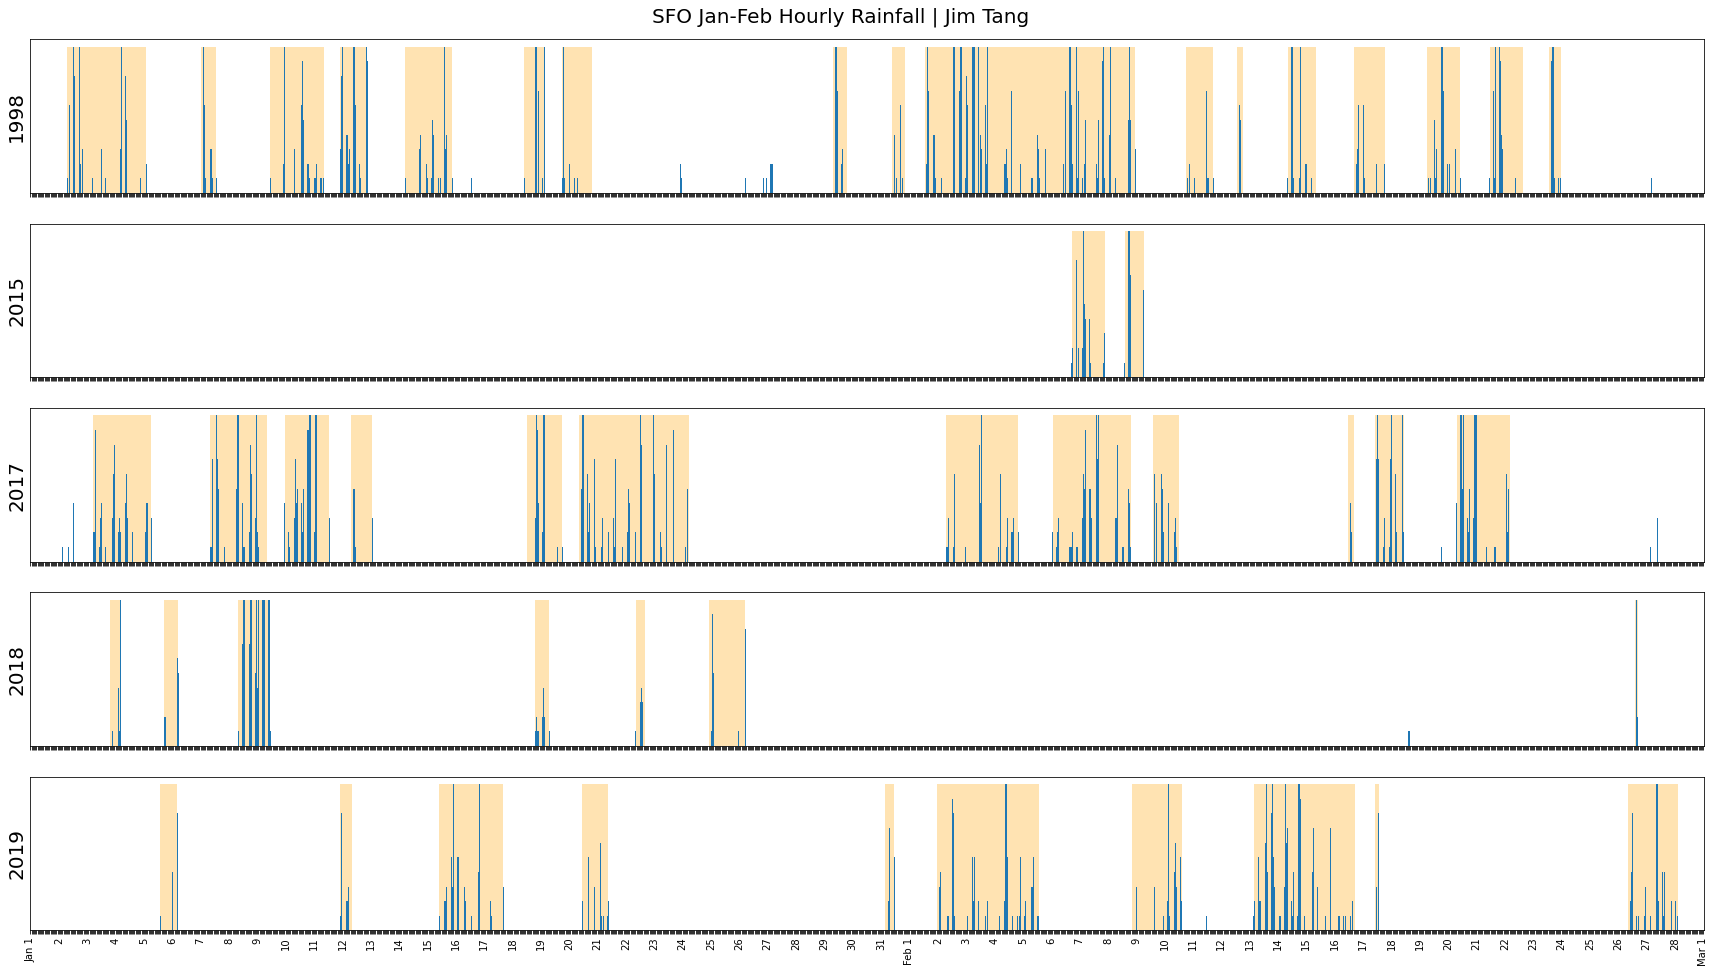

In [863]:
years = [1998, 2015, 2017, 2018, 2019]
events_by_year = {}

fig, axes = plt.subplots(len(years), 1, sharex=True, figsize=(30, 15))
fig.suptitle('SFO Jan-Feb Hourly Rainfall | Jim Tang', fontsize=20)

for i, yr in enumerate(years):
    _, events = plot_rain_janfeb(yr, full_height=False, ax=axes[i], ylabel=20)
    events_by_year[yr] = events
    
plt.subplots_adjust(top=0.95)

In [854]:
events_by_year[2015]

,clust,precip,mean_time,min_time,max_time,max_precip_24hr,max_precip_hr
1683,1683,0.80,2015-02-07 03:45:52.941176576,2015-02-06 17:00:00,2015-02-07 21:00:00,0.75,2015-02-07 09:00:00
1684,1684,1.21,2015-02-08 18:45:00.000000000,2015-02-08 14:00:00,2015-02-09 06:00:00,1.21,2015-02-09 06:00:00
